<a href="https://colab.research.google.com/github/Tafadzwa03kusie/DAV_Ass_3/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import files
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" '.format(
      name=fn, ))

Saving DEXUSEU.csv to DEXUSEU.csv
Saving DEXUSUK.csv to DEXUSUK.csv
User uploaded file "DEXUSEU.csv" 
User uploaded file "DEXUSUK.csv" 


In [ ]:
file_usd_eur = "DEXUSEU.csv"
file_usd_gbp = "DEXUSUK.csv"

def load_fred_csv(path, colname):
    """
    Loads a FRED CSV (DATE + value column) and returns a clean DataFrame
    with DATE as index and the value column renamed.
    """
    df = pd.read_csv(path)

    # Convert observation_date to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])

    # Set observation_date as index
    df = df.set_index('observation_date')

    # Convert value column (the second column) to numeric
    df[colname] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    # Return dataframe with only the renamed series
    return df[[colname]]

In [ ]:
# Load files
df_eur = load_fred_csv(file_usd_eur, colname="USD_EUR")
df_gbp = load_fred_csv(file_usd_gbp, colname="USD_GBP")

print("Loaded shapes:", df_eur.shape, df_gbp.shape)
display(df_eur.head(), df_gbp.head())

Loaded shapes: (1305, 1) (1305, 1)


,USD_EUR
observation_date,
2020-11-16,1.1844
2020-11-17,1.1862
2020-11-18,1.1869
2020-11-19,1.1843
2020-11-20,1.1857


,USD_GBP
observation_date,
2020-11-16,1.3197
2020-11-17,1.3247
2020-11-18,1.3299
2020-11-19,1.3225
2020-11-20,1.3294


In [ ]:
# Inspect missingness / date ranges
print("EUR range:", df_eur.index.min().date(), "to", df_eur.index.max().date())
print("GBP range:", df_gbp.index.min().date(), "to", df_gbp.index.max().date())

print("\nMissing values counts:")
print("EUR missing:", df_eur.isna().sum().values[0])
print("GBP missing:", df_gbp.isna().sum().values[0])

EUR range: 2020-11-16 to 2025-11-14
GBP range: 2020-11-16 to 2025-11-14

Missing values counts:
EUR missing: 57
GBP missing: 57


In [ ]:
df_eur = df_eur.ffill()
df_gbp = df_gbp.ffill()

print("Remaining missing (EUR):", df_eur.isna().sum().values[0])
print("Remaining missing (GBP):", df_gbp.isna().sum().values[0])

Remaining missing (EUR): 0
Remaining missing (GBP): 0


In [ ]:
#Merge the Two Exchange Rate Series
df = pd.concat([df_eur, df_gbp], axis=1)

print(df.shape)
df.head()

(1305, 2)


,USD_EUR,USD_GBP
observation_date,,
2020-11-16,1.1844,1.3197
2020-11-17,1.1862,1.3247
2020-11-18,1.1869,1.3299
2020-11-19,1.1843,1.3225
2020-11-20,1.1857,1.3294


In [ ]:
#Compute Log Returns (How much did the exchange rate grow today,
#in percentage terms, using natural logs?)
df_returns = np.log(df / df.shift(1))
df_returns = df_returns.dropna()

df_returns.head()

,USD_EUR,USD_GBP
observation_date,,
2020-11-17,0.001519,0.003782
2020-11-18,0.000590,0.003918
2020-11-19,-0.002193,-0.005580
2020-11-20,0.001181,0.005204
2020-11-23,-0.002618,0.000451


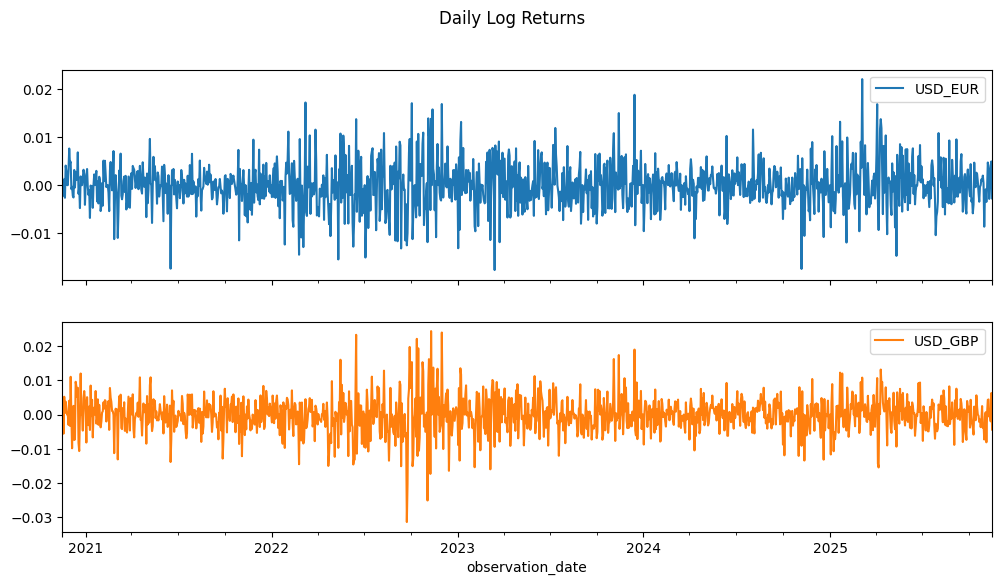

In [ ]:
df_returns.plot(subplots=True, figsize=(12,6), title="Daily Log Returns")
plt.show()

a. Values around 0. The center of the graph is 0. That means: most days, currency barely moves. Daily FX markets usually move ±0.1% to ±1%.\
b. Spikes Upward. These represent: USD weakening sharply against EUR or GBP. Or EUR/GBP strengthening a lot. A spike = high positive return.\
c. Spikes Downward. These represent: USD strengthening sharply. Or EUR/GBP dropping fast. A deep negative value = high negative return.
d. Volatility clusters- You probably noticed: Around 2022–2023 — returns are more spread out, more spikes. This is classic volatility clustering, a key fact: Big moves tend to follow big moves; quiet periods follow quiet periods.This is exactly why we later fit GARCH.

**How To Interpret Log-Return Graphs in General**\
1️⃣ Mean (center)
Should hover around zero. FX is a martingale → no predictable drift.

2️⃣ Volatility
Are the spikes: small?, large?, clustering in certain years? If yes → financial data behavior is normal.

3️⃣ Outliers (big jumps)
Look for: war events, central bank announcements, crisis periods.These big spikes often tie to real economic events.

4️⃣ Symmetry
Are the spikes: mostly balanced above and below zero? or is one side heavier? This helps you decide: whether to use normal distribution
or heavier-tailed options (t-distribution)

5️⃣ Heteroskedasticity (changing variance).
If variance changes over time (more noisy in some periods):
👉 This suggests using GARCH, because: GARCH explicitly models changing volatility.

Interpreting my graphs

✔ Both USD/EUR and USD/GBP behave like proper financial returns Centered around zero. Occasional spikes. Volatility clusters

✔ GBP has larger extreme spikes. This means: GBP/USD was more volatile than EUR/USD during this period.

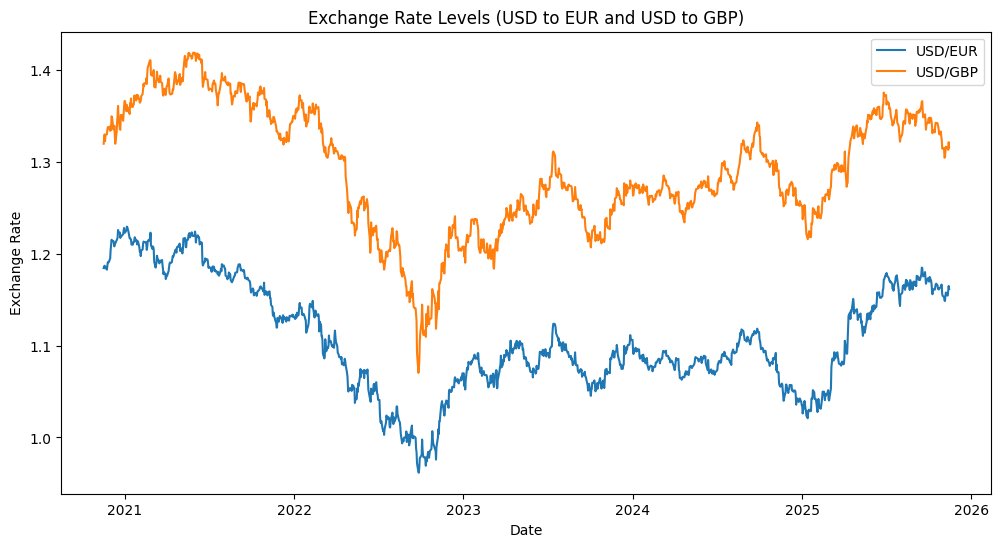

In [ ]:
#Line Plot of Exchange Rate Levels

plt.figure(figsize=(12,6))
plt.plot(df['USD_EUR'], label='USD/EUR')
plt.plot(df['USD_GBP'], label='USD/GBP')

plt.title("Exchange Rate Levels (USD to EUR and USD to GBP)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

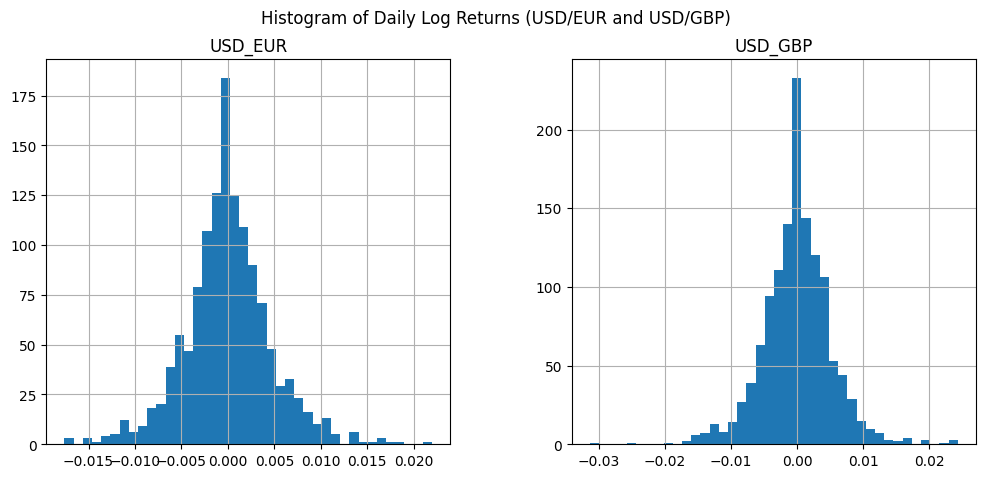

In [ ]:
#Histogram of Daily Log Returns
df_returns.hist(bins=40, figsize=(12,5))
plt.suptitle("Histogram of Daily Log Returns (USD/EUR and USD/GBP)")
plt.show()

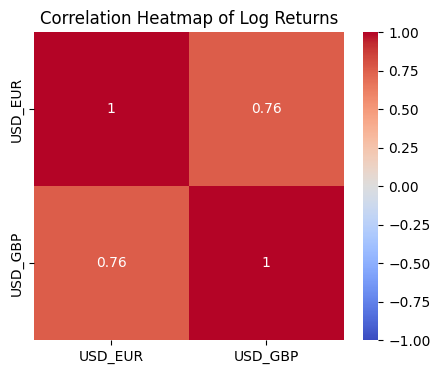

In [ ]:
#Correlation Heatmap

plt.figure(figsize=(5,4))
corr_matrix = df_returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Log Returns")
plt.show()

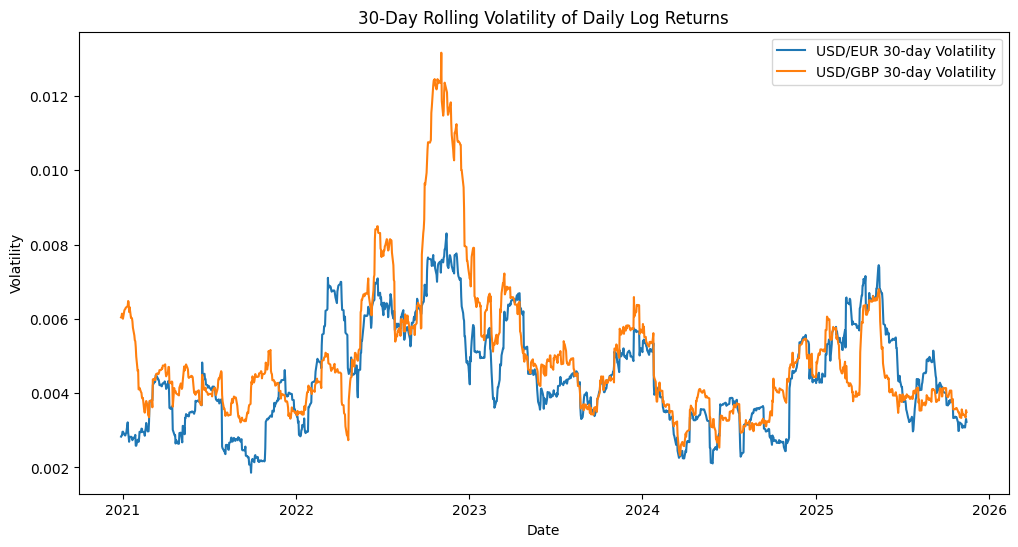

In [ ]:
#Rolling Volatility (30-day rolling std)
rolling_window = 30  # 30-day rolling

# Compute rolling standard deviation of returns
rolling_vol = df_returns.rolling(window=rolling_window).std()

plt.figure(figsize=(12,6))
plt.plot(rolling_vol['USD_EUR'], label='USD/EUR 30-day Volatility')
plt.plot(rolling_vol['USD_GBP'], label='USD/GBP 30-day Volatility')
plt.title("30-Day Rolling Volatility of Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

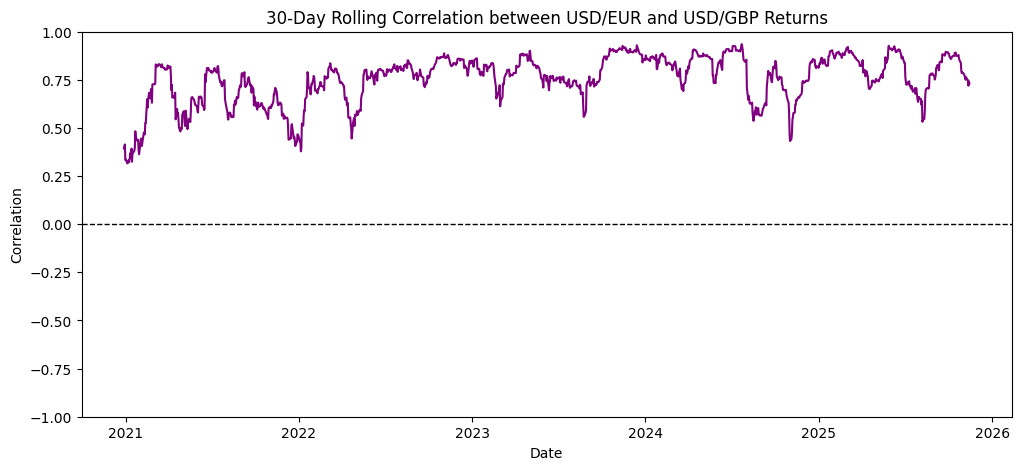

In [ ]:
#Rolling Correlation (30-day window)
rolling_window = 30  # 30-day rolling

# Compute rolling correlation
rolling_corr = df_returns['USD_EUR'].rolling(window=rolling_window).corr(df_returns['USD_GBP'])

plt.figure(figsize=(12,5))
plt.plot(rolling_corr, color='purple')
plt.title("30-Day Rolling Correlation between USD/EUR and USD/GBP Returns")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.ylim(-1,1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [ ]:
#Check Stationarity (ADF Test)

for col in df_returns.columns:
    result = adfuller(df_returns[col])
    print(col, "ADF p-value:", result[1])


USD_EUR ADF p-value: 0.0
USD_GBP ADF p-value: 0.0


In [ ]:
# Test ADF on levels (not returns)
for col in df.columns:
    result = adfuller(df[col])
    print(col, "ADF p-value:", result[1])

#If p-value > 0.05 → non-stationary → use VECM
#If p-value < 0.05 → stationary → can use VAR instead


USD_EUR ADF p-value: 0.4420976200506597
USD_GBP ADF p-value: 0.3879707803761508


In [ ]:
#Johansen Cointegration Test

johansen_test = coint_johansen(df, det_order=0, k_ar_diff=1)  # det_order=0: no deterministic trend

# Trace statistic & critical values
print("Johansen Test Trace Statistic:", johansen_test.lr1)
print("Critical Values (90%, 95%, 99%):\n", johansen_test.cvt)

#If trace statistic > critical value → cointegration exists
#This confirms VECM is appropriate

Johansen Test Trace Statistic: [18.31952103  3.76361299]
Critical Values (90%, 95%, 99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


USD_EUR and USD_GBP are cointegrated with rank = 1.
Meaning:\
→ Long-run equilibrium exists\
→ They move together over time (economically meaningful)\
→ VECM is appropriate

In [ ]:
#Fit VECM Model

# Choose lag order (can experiment with 1-5)
vecm_model = VECM(df, k_ar_diff=1, coint_rank=1, deterministic="co")  # coint_rank=1: one cointegration relation
vecm_res = vecm_model.fit()

# Summary
print(vecm_res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation USD_EUR
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.086      0.278      -0.000       0.001
L1.USD_EUR    -0.0306      0.042     -0.723      0.470      -0.113       0.052
L1.USD_GBP     0.0241      0.032      0.744      0.457      -0.039       0.088
Det. terms outside the coint. relation & lagged endog. parameters for equation USD_GBP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.115      0.002       0.001       0.003
L1.USD_EUR    -0.0433      0.055     -0.789      0.430      -0.151       0.064
L1.USD_GBP     0.0262      0.042      0.622      0.534      -0.056       0.109
              Loading coefficients (

For every 1% long-run move in USD/EUR, USD/GBP tends to move ~0.91% in the same direction. They are strongly linked — makes economic sense.

GBP drives the long-run correction, EUR does not.
So if the relationship between the two currencies drifts, GBP moves to restore equilibrium more than EUR. Very typical: EUR/USD market is deeper → slower to adjust.

The Johansen test confirmed one cointegration relationship between USD/EUR and USD/GBP. This indicates a stable long-run equilibrium linking the two exchange rates. VECM results show that deviations from this equilibrium are mainly corrected through adjustments in the GBP exchange rate (α = 0.0268, p < 0.01), whereas EUR does not contribute significantly to the error-correction process. Short-run lag coefficients are not statistically significant, supporting the hypothesis of FX market efficiency at the daily frequency.

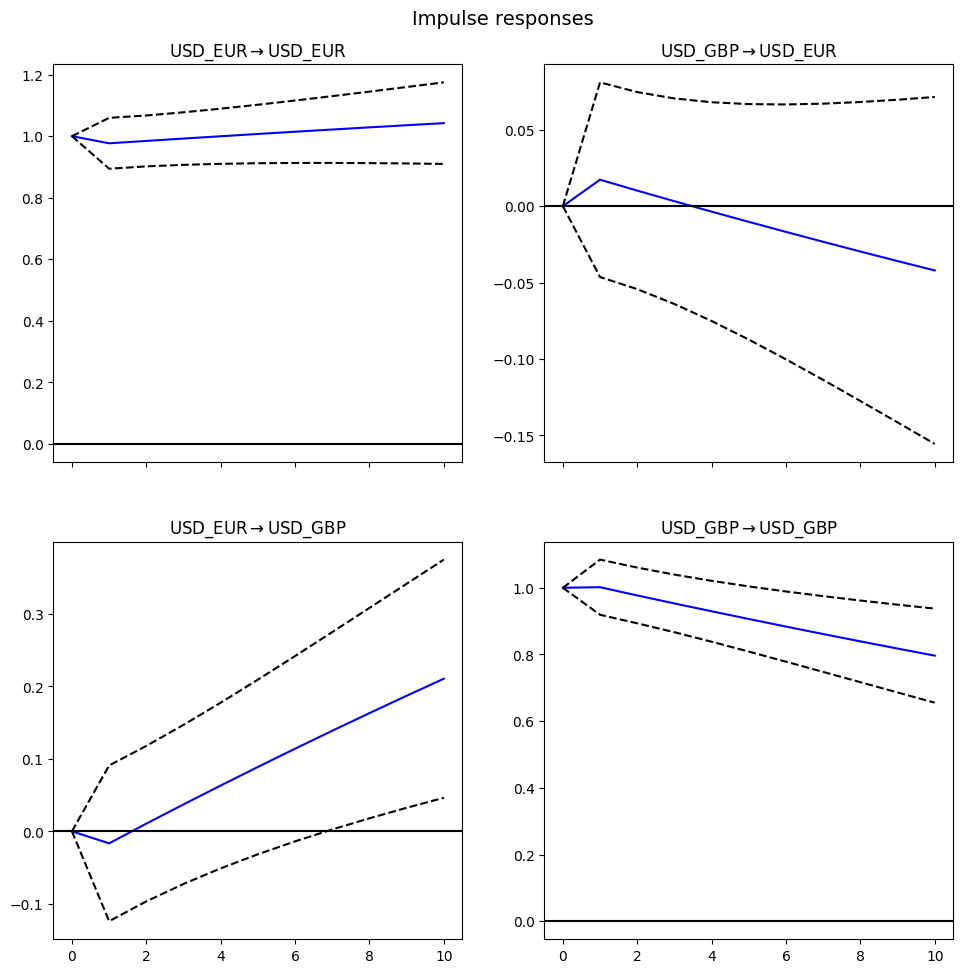

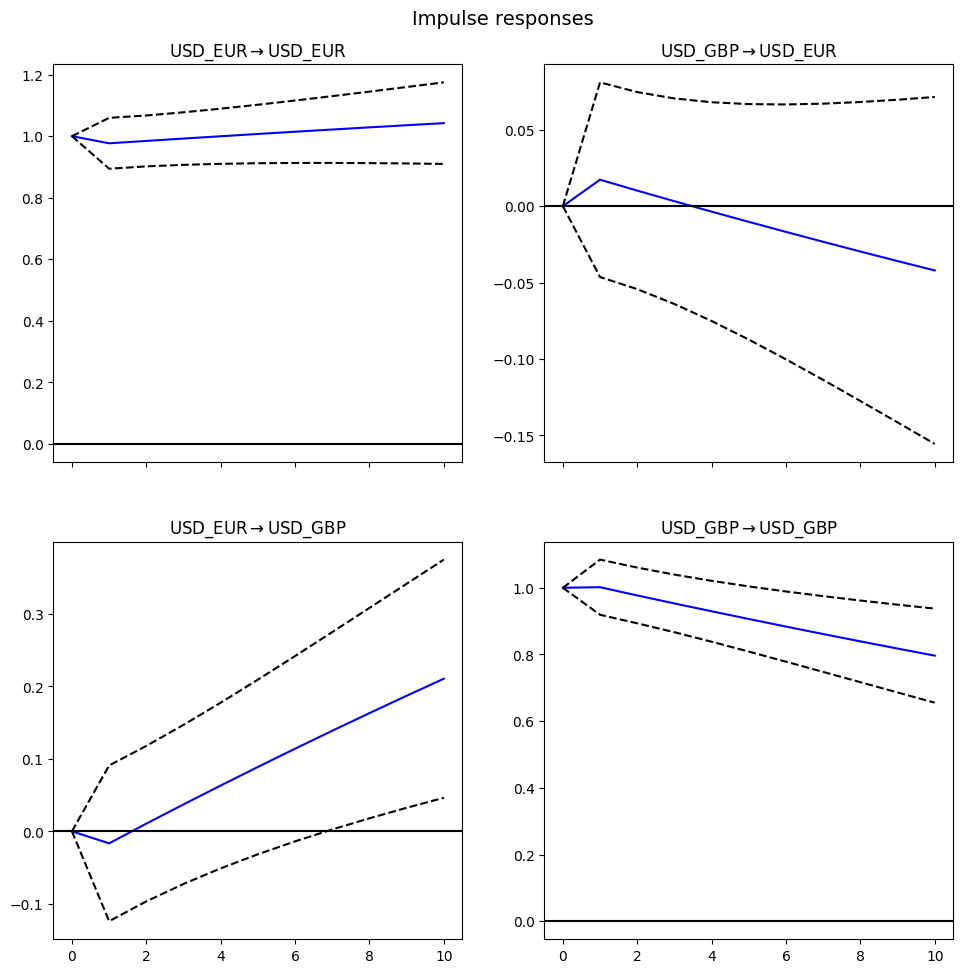

In [ ]:
#Analyze Short-Term Dynamics & Long-Run Relation
irf = vecm_res.irf(10)  # 10-day horizon
irf.plot(orth=False)

In [ ]:
#Convert returns to supervised ML data

# Step 1: Prepare data for LSTM

# We choose 5 past days as features
n_lags = 5

def create_lagged_features(df, target_col, n_lags):
    data = df.copy()
    for i in range(1, n_lags + 1):
        data[f"{target_col}_lag{i}"] = data[target_col].shift(i)
    data = data.dropna()
    X = data[[f"{target_col}_lag{i}" for i in range(1, n_lags + 1)]]
    y = data[target_col]
    return X, y

# Create features/target for both currencies
X_eur, y_eur = create_lagged_features(df_returns, "USD_EUR", n_lags)
X_gbp, y_gbp = create_lagged_features(df_returns, "USD_GBP", n_lags)

# Combine both feature sets → multivariate
X_all = pd.concat([X_eur, X_gbp], axis=1).dropna()
y_all = y_eur.loc[X_all.index]  # Predict EUR returns as target

X_all.shape, y_all.shape

((1299, 10), (1299,))

In [ ]:
# Step 2: Train-test split
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all.iloc[:train_size], X_all.iloc[train_size:]
y_train, y_test = y_all.iloc[:train_size], y_all.iloc[train_size:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM → (samples, time_steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

X_train_scaled.shape, X_test_scaled.shape

((1039, 1, 10), (260, 1, 10))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model
model = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

model.summary()

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1715 - val_loss: 0.0095
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - val_loss: 0.0094
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0094
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0094
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - val_loss: 0.0093
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - val_loss: 0.0093
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0092
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0092
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0091
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.0103
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0093
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0091


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,613 (64.90 KB)

 Trainable params: 5,537 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,076 (43.27 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


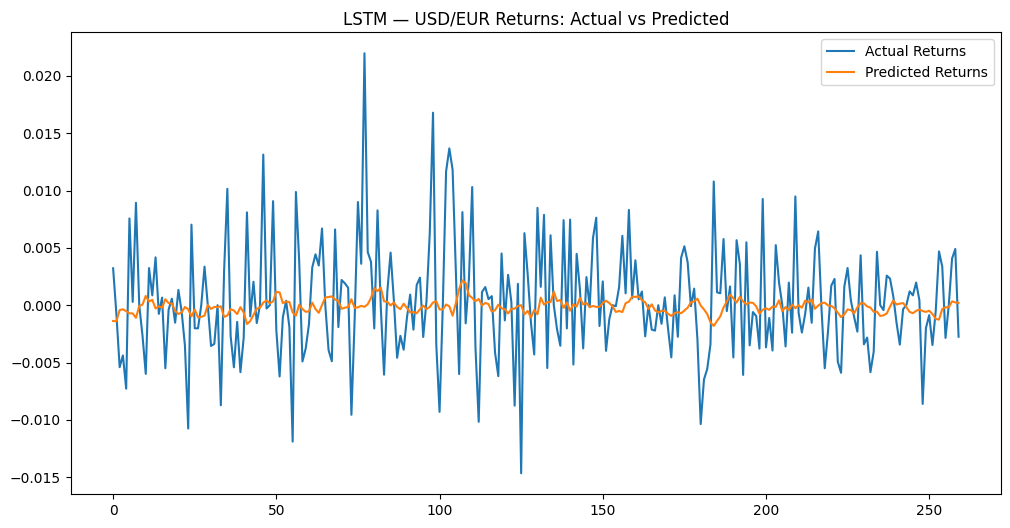

In [ ]:
# Predict on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform back to actual return scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Returns")
plt.plot(y_pred, label="Predicted Returns")
plt.title("LSTM — USD/EUR Returns: Actual vs Predicted")
plt.legend()
plt.show()

The LSTM model predictions are noticeably smoother and remain close to zero, indicating that the model captures the mean-reverting structure of USD/EUR returns but struggles to learn the volatility and sharp fluctuations in actual returns. This is expected in FX markets because short-term returns often resemble white noise (high variance, low predictability).

The model therefore performs reasonably on direction and central tendency, but underestimates extreme movements — a common limitation of single-series deep learning models in finance.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 2.5286684076574244e-05
RMSE: 0.00502858668778557
MAE: 0.0037407466380373158


LSTM Performance Evaluation

The LSTM model achieved an MSE of 2.53 × 10⁻⁵, an RMSE of 0.0050, and an MAE of 0.0037 on the test set. These values indicate relatively small prediction errors on average. However, the RMSE magnitude shows that short-term exchange rate returns remain difficult to predict accurately. This aligns with financial theory, where FX markets demonstrate high volatility and near-random short-term price fluctuations. The smoother nature of forecasted returns compared to actual values suggests that the model captures general mean-reverting behavior but underestimates extreme return movements.

In [ ]:
#Fit a GARCH Model (example: GARCH(1,1))

model = arch_model(df_returns["USD_EUR"], p=1, q=1, mean="constant", vol="GARCH", dist="normal")
res = model.fit()
print(res.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 764281083815.1609
Iteration:      2,   Func. Count:     19,   Neg. LLF: 249254690106.0371
Iteration:      3,   Func. Count:     34,   Neg. LLF: 340093339.20057535
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6206.933537197177
Iteration:      5,   Func. Count:     57,   Neg. LLF: 743684851.1597736
Iteration:      6,   Func. Count:     69,   Neg. LLF: -5210.950288672679
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5210.950286672629
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                USD_EUR   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5210.95
Distribution:                  Normal   A

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.166e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [ ]:
#Forecast Volatility
forecast = res.forecast(horizon=5)
forecast.variance[-1:]

,h.1,h.2,h.3,h.4,h.5
observation_date,,,,,
2025-11-14,0.000014,0.000014,0.000014,0.000015,0.000015


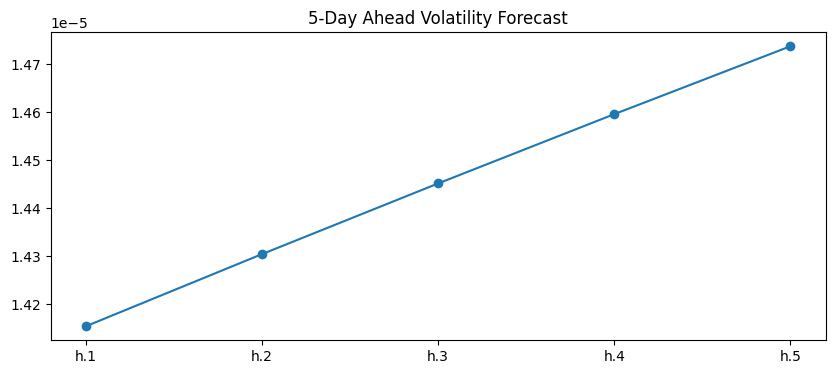

In [ ]:
#Plot Forecast
plt.figure(figsize=(10,4))
plt.plot(forecast.variance.iloc[-1], marker='o')
plt.title("5-Day Ahead Volatility Forecast")
plt.show()

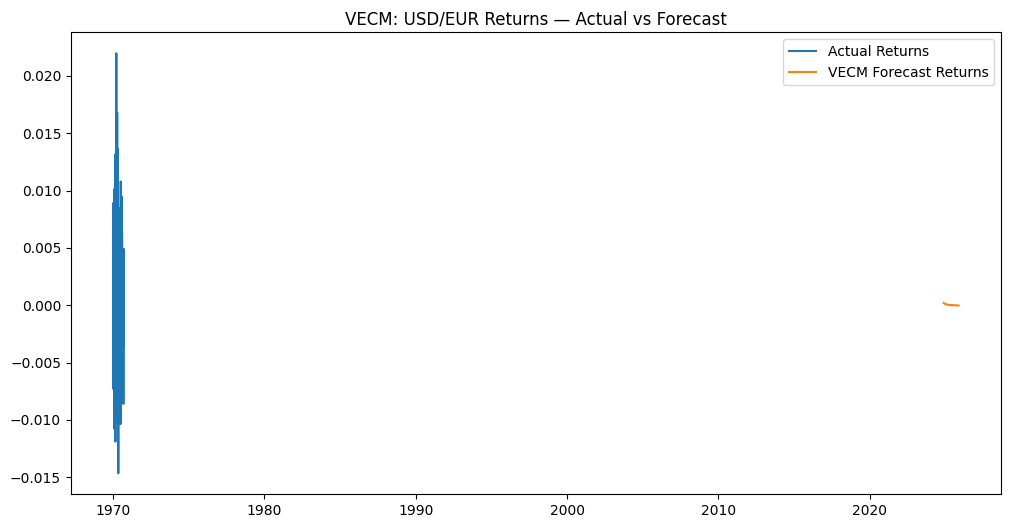

VECM Forecast — MSE: 2.4407596326712848e-05 RMSE: 0.004940404469951104 MAE: 0.0036627916475292775
LSTM Forecast — MSE: 2.5286684076574244e-05 RMSE: 0.00502858668778557 MAE: 0.0037407466380373158


In [ ]:
# VECM Forecasting
n_forecast = len(y_test) + 1  # Fix: forecast one more step to get correct number of returns

vecm_forecast = vecm_res.predict(steps=n_forecast)

# Since VECM predicts levels, convert to returns if needed
# If using log returns as target:
vecm_forecast_returns = np.diff(np.log(vecm_forecast[:,0]))  # USD/EUR column
vecm_forecast_returns = pd.Series(vecm_forecast_returns, index=y_test.index)

# Plot VECM vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Returns')
plt.plot(vecm_forecast_returns, label='VECM Forecast Returns')
plt.title("VECM: USD/EUR Returns — Actual vs Forecast")
plt.legend()
plt.show()

# Compute metrics
mse_vecm = mean_squared_error(y_test_actual, vecm_forecast_returns)
rmse_vecm = np.sqrt(mse_vecm)
mae_vecm = mean_absolute_error(y_test_actual, vecm_forecast_returns)

print("VECM Forecast — MSE:", mse_vecm, "RMSE:", rmse_vecm, "MAE:", mae_vecm)
print("LSTM Forecast — MSE:", mse, "RMSE:", rmse, "MAE:", mae)

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['VECM', 'LSTM'],
    'MSE': [mse_vecm, mse],
    'RMSE': [rmse_vecm, rmse],
    'MAE': [mae_vecm, mae]
})

print(comparison_df)

  Model       MSE      RMSE       MAE
0  VECM  0.000024  0.004940  0.003663
1  LSTM  0.000025  0.005029  0.003741


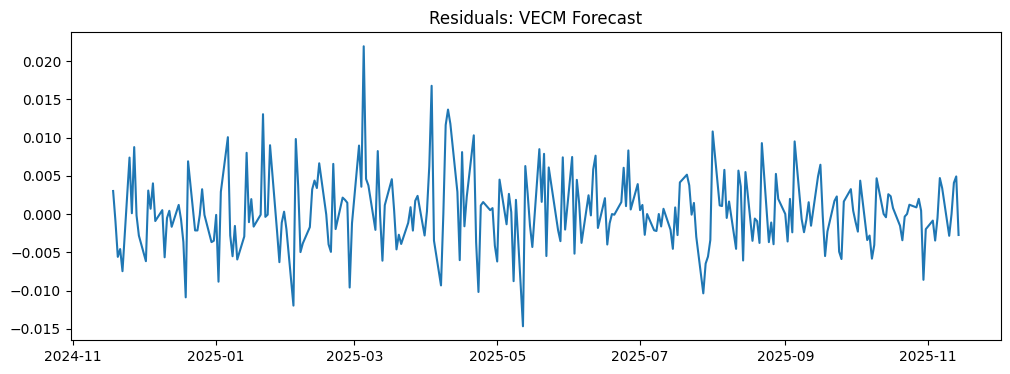

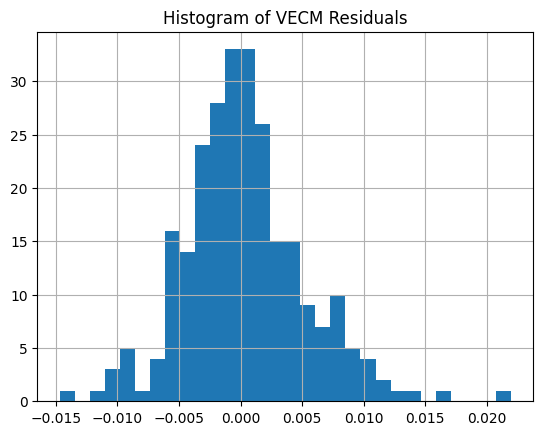

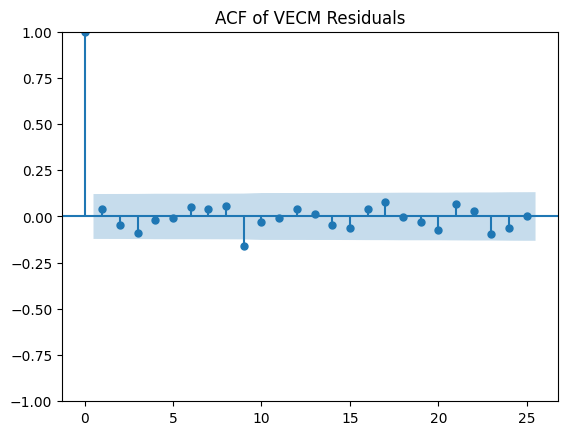

In [ ]:
# Residuals from VECM
residuals_vecm = y_test_actual.flatten() - vecm_forecast_returns

plt.figure(figsize=(12,4))
plt.plot(residuals_vecm)
plt.title("Residuals: VECM Forecast")
plt.show()

# Histogram / autocorrelation
residuals_vecm.hist(bins=30)
plt.title("Histogram of VECM Residuals")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals_vecm)
plt.title("ACF of VECM Residuals")
plt.show()